# Beispiel Skript für Versuch 8 - Oszilloskop

In dieser Datei wird das Einleisen und Anpassen von Daten aus einem Oszilloskop demonstriert. Diese Funktionen werden für den dritten Punkt von Aufgabe 1 benötigt. Stelle sicher, dass alle Zellen mittels Shift-Enter ausgeführt werden.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Einlesen der Daten aus der CSV Datei des Ostilloskops

Die CSV Exportierfunktion des Oszilloskops generiert Daten, die nicht direkt mit der CSV-Einleseroutine von Numpy kompatibel sind. Mit dem Befehl  ```osc_array = load_oscilloscope_data(filename)``` wird 

Die Funktion gibt die Daten in einem 2 dimensionalen ```numpy.array``` zurück. 

Die Sampling-Zeitpunkte relativ zum Triggerzeitpunkt können mit ```time_array = osc_array[:,0]``` aufgerufen werden.

Die sigitalisierten Spannungen des ersten Eingangskanals mit ```volt_ch1 = osc_array[:,1]``` und des zweiten Eingangskanals mit ```volt_ch2 = osc_array[:,]```

In [2]:
def load_oscilloscope_data(filename):
    """Loads CSV data from a RIGOL oscilloscope
    This is not a standard CSV file:
        - The data has an additional comma "," at the end of every line, so we have to specify he number of columns to use with usecol
        - The time data is not saved. We only get the start time and time increment in the second line of the datafile

    data_array = load_oscilloscope(filename)
    
    This functions reads in the data and returns an array with the dimenstion [N_sample, Channels+1]

    The time data can be retrieved with:

    data_array[:,0]

    The first channel with

    data_array[:,1]

    and the second channel (if available) with

    data_array[:,2]
    """
    with open(filename) as f:
        first_line = f.readline()
        no_channels = first_line.count('CH')
        second_line = f.readline()
        second_list = second_line.split(',')
        start_time = float(second_list[-2])
        time_increment = float(second_list[-1])
    ch_data = np.loadtxt(filename, skiprows=2, delimiter=',', usecols=[1,no_channels])
    all_data = np.zeros([ch_data.shape[0], ch_data.shape[1]+1])
    print(all_data.shape)
    all_data[:,1:] = ch_data
    all_data[:,0] = np.arange(ch_data.shape[0]) * time_increment + start_time
    return all_data



Die Daten können wie üblich mithilfe von```plt.plot(x,y)``` dargestellt werden. In diesem Fall ist der Datenbreich der X-Achse einige hundert Nanosekunden. Deswegen multiplizieren wir die Zeitachse mit $10^9$, was als `1e9`geschrieben werden kann.

(60, 3)


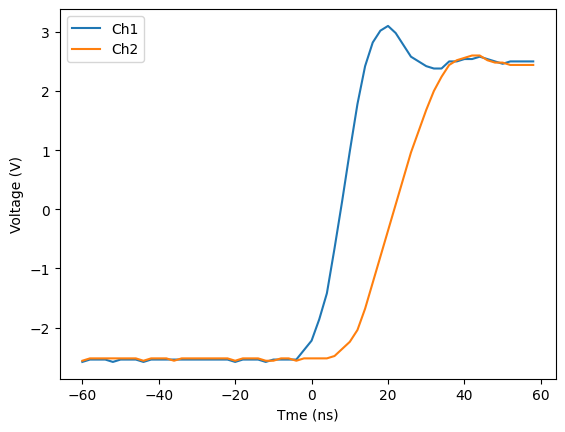

In [3]:
osc_data = load_oscilloscope_data('SignalSpeed_NotTerminated.csv')
plt.plot(osc_data[:,0] * 1e9, osc_data[:,1], label='Ch1')
plt.plot(osc_data[:,0] * 1e9, 10*osc_data[:,2], label='Ch2')
plt.xlabel('Tme (ns)')
plt.ylabel('Voltage (V)')
plt.legend(loc='best')
plt.savefig('Example_oscilloscope_trace.pdf')

## Anpassen von nichtlinearen Funktionen

Im folgenden wird `scipy.curve_fit` verwendet, um die Daten an eine Sinusfunktion anzupassen. 

Wir definieren dazu zuerst eine Funktion `sine_func`, die einen Sinus mit gegebenem Offset, Amplitude, und Kreisfrequenz berechnet.

Die Anpassungsroutine benötigt geratene Anfangsparameter, die den angepassten Parametern ungefähr entsprechen sollte. Je nach Fitfunktion und Qualität der Daten ist es hier ratsam, die Parameter im vorhinein auf einen Faktor zwei abzuschätzen.

Die Anfangsparameter werden der Anpassfunktion `scipy.curve_fit` in einer Liste `InitialValues = [offset,amplitude,omega]` übergeben. Die Reoihenfolge dieser Liste muss der Reihenfolge der Paramters (ohne $x$) in der Funktion `sine_func` entsprechen!

Die Anpassung wird mit dem Befehl `OptimalValues, CovarianceMatrix = curve_fit(sine_func,x,y, p0 = InitialValues)` durchgeführt. 

Die angepassten Parameter werden in der Liste `OptimalValues` zurückgegeben. Die Reihenfolge der Parameter ist wiederum dieselbe.

In [4]:

def sine_func(x, phase, offset, amplitude, omega): 
    """Calculates the sine for the array given by x
    with paramters: 
    phase,
    offset, 
    amplitude, 
    angular frequency in rad/s: omega 
    """
    return offset + amplitude * np.sin(omega*x + phase) 


osc_data = load_oscilloscope_data('sine_single_channel.csv')

x = osc_data[:,0]
y = osc_data[:,1]

InitialValues = [0,0,3,2*np.pi*1e7]
OptimalValues, CovarianceMatrix = curve_fit(sine_func,x,y, p0 = InitialValues)
print(f'Fitted parameters: Phase:  {OptimalValues[0]:.2f} Offset: {OptimalValues[1]:.2f}, Amplitude: {OptimalValues[2]:.2f}, Angular Frequency: {OptimalValues[3]:.2f}')

(1200, 3)
Fitted parameters: Phase:  0.00 Offset: -0.04, Amplitude: 2.53, Angular Frequency: 62820091.18


Um die angepasste Funktion mit den ermittelten Parametern darzustellen, muss die Fitfunktion mit den Zeitwerten evaluiert und in eine Liste gespeichert werden.

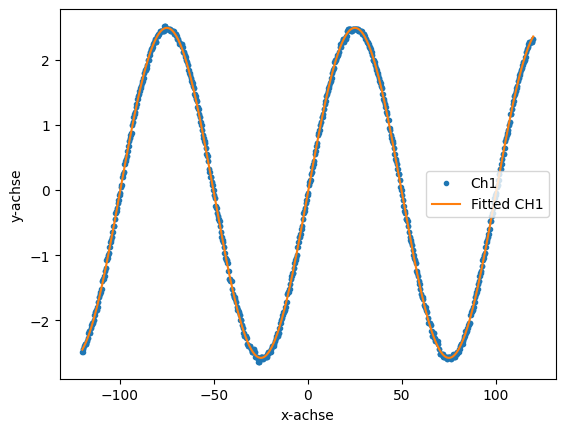

In [11]:
fitted_data = sine_func(osc_data[:,0], OptimalValues[0], OptimalValues[1], OptimalValues[2], OptimalValues[3])
plt.plot(osc_data[:,0] * 1e9, osc_data[:,1],'.', label='Ch1')
plt.plot(osc_data[:,0] * 1e9, fitted_data, label='Fitted CH1')
plt.xlabel('x-achse')
plt.ylabel('y-achse')
plt.legend(loc='best')
plt.savefig('Example_oscilloscope_fitting.pdf')

Die Unsicherheiten der ermittelten Parametern entsprechen den Diagonalelementen der Kovarianzmatrix, welche in der Variable `CovarianceMatrix` gespeichert ist.

In [6]:
diagonal_cov = np.diag(CovarianceMatrix)
print(f'Phase {OptimalValues[0]:.3f} +- {np.sqrt(diagonal_cov[0]):.3f}')
print(f'Offset {OptimalValues[1]:.3f} +- {np.sqrt(diagonal_cov[1]):.3f}')
print(f'Amplitude {OptimalValues[2]:.3f} +- {np.sqrt(diagonal_cov[2]):.3f}')
print(f'Angular Frequency {OptimalValues[3]:.3f} +- {np.sqrt(diagonal_cov[3]):.3f}')

Phase 0.003 +- 0.000
Offset -0.044 +- 0.001
Amplitude 2.534 +- 0.001
Angular Frequency 62820091.180 +- 6358.768
